In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

e:\all_programs\anaconda\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 66.0M/66.0M [01:52<00:00, 616kB/s] 

Extracting files...


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


In [3]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [5]:
df = df.sort_values("Time")

split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
val_df = df.iloc[split_idx:]

X_train = train_df.drop("Class", axis=1)
y_train = train_df["Class"]

X_val = val_df.drop("Class", axis=1)
y_val = val_df["Class"]

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train, y_train
)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_resampled["Amount_scaled"] = scaler.fit_transform(
    X_train_resampled[["Amount"]]
)

X_val["Amount_scaled"] = scaler.transform(
    X_val[["Amount"]]
)

In [9]:
import numpy as np

X_train_resampled["log_amount"] = np.log1p(X_train_resampled["Amount"])
X_val["log_amount"] = np.log1p(X_val["Amount"])

In [10]:
X_train_resampled["time_diff"] = X_train_resampled["Time"].diff().fillna(0)
X_val["time_diff"] = X_val["Time"].diff().fillna(0)

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

lr.fit(X_train_resampled, y_train_resampled)

e:\all_programs\anaconda\envs\llm\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_resampled, y_train_resampled)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=20,
    eval_metric="aucpr",
    random_state=42
)

xgb.fit(X_train_resampled, y_train_resampled)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [24]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
probs = [5.25,5.0]
def evaluate(model):
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1]
    print(probs)
    print(classification_report(y_val, preds))
    print("ROC-AUC:", roc_auc_score(y_val, probs))
    print("PR-AUC:", average_precision_score(y_val, probs))

In [25]:
evaluate(xgb)

[5.7433968e-05 7.8581079e-06 6.2916610e-05 ... 4.9824030e-05 3.9345512e-05
 8.4684405e-04]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.88      0.76      0.81        75

    accuracy                           1.00     56962
   macro avg       0.94      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9677273659476975
PR-AUC: 0.7783639059302224


In [27]:
probs = np.array(probs)
threshold = 0.3

custom_preds = (probs > threshold).astype(int)

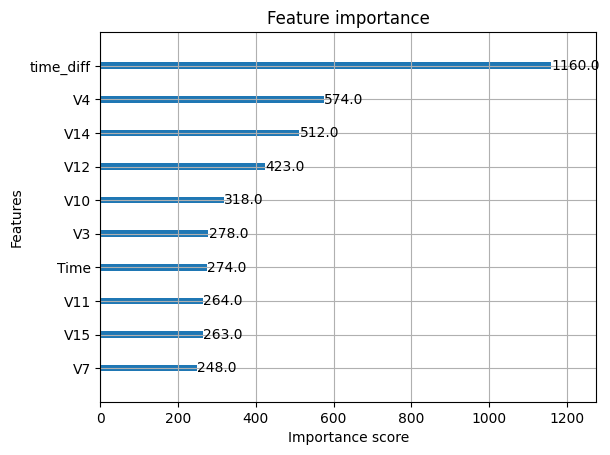

In [28]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb, max_num_features=10)
plt.show()


In [30]:
import joblib

joblib.dump(xgb, "models/fraud_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']